In [4]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython scipy
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import Phylo
import os
from scipy.stats import fisher_exact
import string

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


Lets start by identifying transposable elements which are significantly enriched within the centromeres.
We will do this by counting their presence and absence inside the centromeres, then conducting a fishers exact test to identify ones that are biased towards the centromere.
For simplicity, I will not be conducting any multiple measures correction.
There's an argument against this anyway - really I'm just considering the p-value as a "surprise factor" rather than some measure of truthyness.
Plenty of post-filtering and "BIG THINKING" will be done anyway, so not overly important.

In [31]:
# Find earlgrey TEs that lie inside the centromeres

centromeres = (
    pl.read_csv(
        "../results/cenh3/centromeres.bed",
        separator="\t",
        has_header=False,
    )
    .select(
        chrom="column_1",
        start="column_2",
        end="column_3",
    )
)

earlgrey_gff = (
    pl.read_csv(
        "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
        separator="\t",
        has_header=False,
    )
    .with_columns(
        pl.col("column_9").str.extract(r"ID=(.*?);").alias("ID"),
    )
    .select(
            chrom="column_1",
            te_type="column_3",
            start="column_4",
            end="column_5",
            id="ID",
    )
    .filter(
        pl.col('id').str.contains("RND"),
    )
)

earlgrey_intersecting = (
    earlgrey_gff.join(centromeres, on="chrom", how="inner")
    .with_columns(
        ((pl.col("start") > pl.col("start_right")) &
        (pl.col("end") < pl.col("end_right")))
        .alias("inside_centromere")
    )
)

pivoted = (
    earlgrey_intersecting
    .group_by(["id", "inside_centromere"]).count()
    .pivot(
        values="count",
        index="id",
        columns="inside_centromere",
        aggregate_function="first",
    )
    .fill_null(0)
    .with_columns(
        (pl.col("true") + pl.col("false")).alias("total"),
    )
)

total_inside = pivoted.select(pl.col("true")).sum().item()
total_outside = pivoted.select(pl.col("false")).sum().item()

results = []
for row in pivoted.iter_rows(named=True):
    contingency_table = [
        [row["true"], row["false"]],
        [total_inside - row["true"], total_outside - row["false"]],
    ]

    odds_ratio, p_value = fisher_exact(contingency_table)

    results.append(
        {
            "id": row["id"],
            "odds_ratio": odds_ratio,
            "p_value": p_value,
        }
    )

results_df = pl.DataFrame(results)

results_df.write_csv("../results/earlgrey_centromere_enrichment.csv")

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_1556/3392376243.py:48: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .group_by(["id", "inside_centromere"]).count()


Lets summarise which TEs are centromere biased! I'm going slightly mad!

First, what is the distribution of odds ratios like? Need a cutoff for ones that are like super associated - it's all arbitrary really...

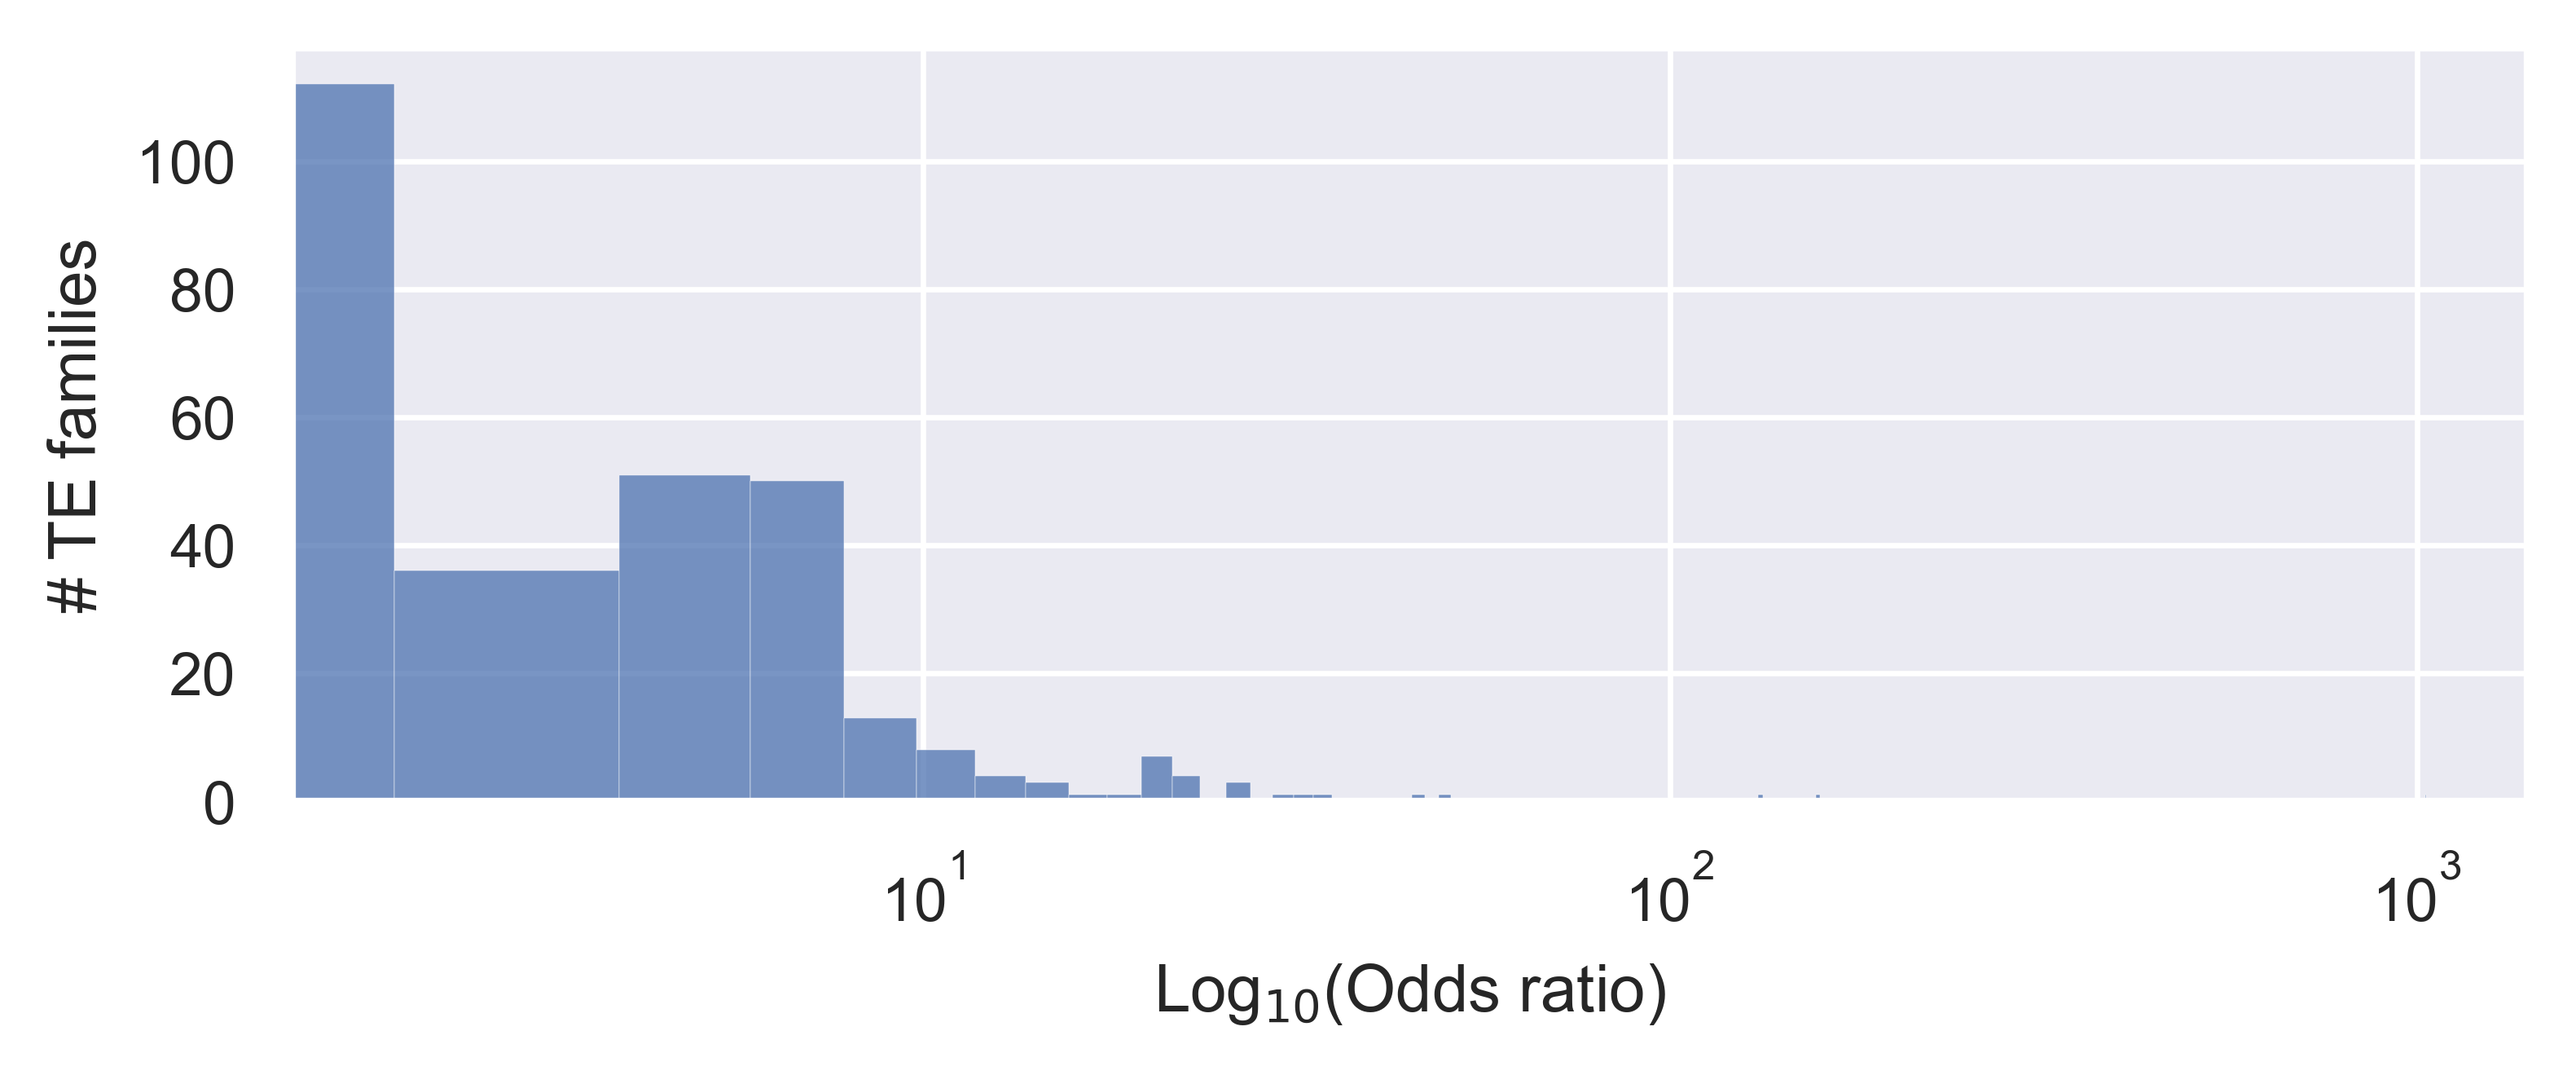

In [6]:
plt.figure(figsize=(5.9, 2), dpi=600)
sns.histplot(
    (
        results_df
        .filter((pl.col("p_value") < 0.001))
    ),
    x="odds_ratio",
)
plt.xscale("log")
plt.xlabel("Log$_{10}$(Odds ratio)")
plt.ylabel("# TE families")
plt.savefig(
    "../../pandoc-thesis/figures/earlgrey_centromere_bias_dist.png",
)

Looks like a cutoff of >10 will be good for identifying the big hitters...

In [7]:
display(
    results_df
    .join((earlgrey_gff.select("id", "te_type").unique()), on="id", how="left")
    .filter((pl.col("p_value") < 0.05) & (pl.col("odds_ratio") > 10))
    .group_by("te_type")
    .agg(
        pl.col("id").count().alias("count"),
    )
)

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_1556/710879025.py:2: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  results_df


te_type,count
str,u32
"""LTR/Caulimovirus""",1
"""Unknown""",13
"""LTR/Gypsy""",25
"""Satellite""",7


Seems to be mostly Ty3 elements, lets examine these closer by looking at the TEsorter classifications.

In [8]:
tesorter = (
    pl.read_csv(
        "../results/tesorter/earlgrey.cls.tsv",
        separator="\t",
    )
    .with_columns(
        pl.col("#TE").str.to_uppercase().str.extract(r"^(.*?)#").alias("id"),
    )
)

tesorted_results = (
    results_df
    .filter((pl.col("p_value") < 0.05) & (pl.col("odds_ratio") > 10))
    .join(tesorter, on="id", how="inner")
    .select("#TE", "odds_ratio", "p_value", "Order", "Clade", "Complete")
    .sort("odds_ratio", descending=True)
)

with pl.Config() as cfg, open("../../pandoc-thesis/figures/tesorter_centromeres.txt", "w") as f:
    cfg.set_tbl_formatting("ASCII_HORIZONTAL_ONLY")
    cfg.set_tbl_hide_column_data_types(True)
    cfg.set_tbl_rows(-1)
    print(tesorted_results, file=f)

What is the distribution of these elements across the chromosomes?

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_1556/474353235.py:5: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


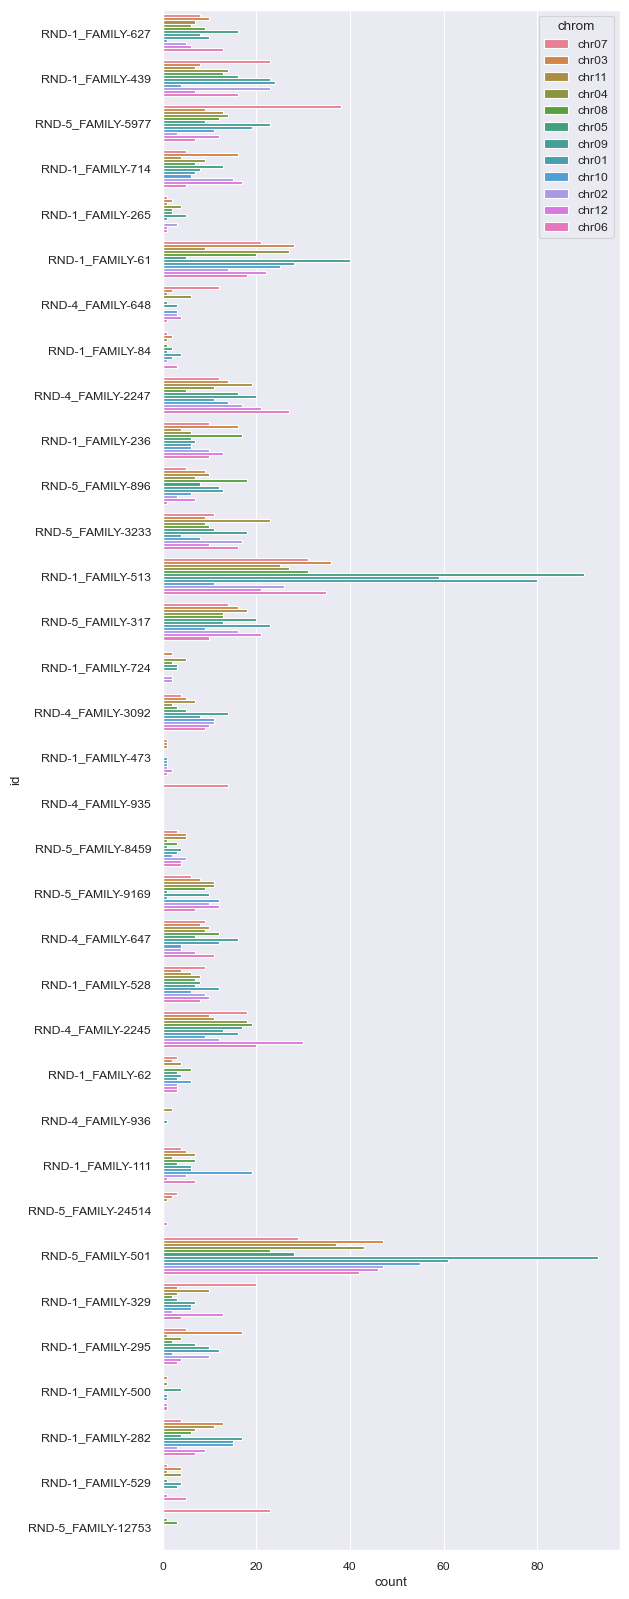

In [9]:
earlgrey_chr_counts = (
    earlgrey_gff
    .filter(pl.col("chrom").str.contains("chr"))
    .group_by(["id", "chrom"])
    .count()
    .join(
        (
            tesorted_results
            .with_columns(
                pl.col("#TE").str.extract(r"^(.*?)#").str.to_uppercase().alias("id"),
            )
        ),
        on="id",
        how="inner",
    )
)

plt.figure(figsize=(5.9, 20))
sns.barplot(
    earlgrey_chr_counts,
    y="id",
    x="count",
    hue="chrom"
)
plt.savefig("../results/ehhhhh.png")

Cool so looks like a lot of CRMs in Tekay elements.
That table is saved for the thesis, so lets now look at CENH3 read mapping.

In [10]:
# ONLY RUN ON CLUSTER MY LAPTOP CAN'T HANDLE THIS

q1 = (
    pl.scan_csv(
        "../results/cenh3/earlgrey_cenh3.bed",
        separator="\t",
        has_header=False,
    )
    .with_columns(
        pl.col("column_9").str.extract(r"ID=(.*?);").alias("ID"),
    )
    .select(["ID", "column_3", "column_11"])
    .group_by("ID", "column_3")
    .agg(pl.mean("column_11").alias("sum"))
)

earlgrey_cenh3 = q1.collect(streaming=True)

earlgrey_cenh3.write_csv("../results/earlgrey_cenh3_summary.csv")

FileNotFoundError: No such file or directory (os error 2): ../results/cenh3/earlgrey_cenh3.bed

This error occurred with the following context stack:
	[1] 'csv scan' failed
	[2] 'with_columns' input failed to resolve
	[3] 'select' input failed to resolve
	[4] 'group_by' input failed to resolve


Begin by looking at the CenH3 mapping
OOps I named the mean as sum... I aint rerunning that...

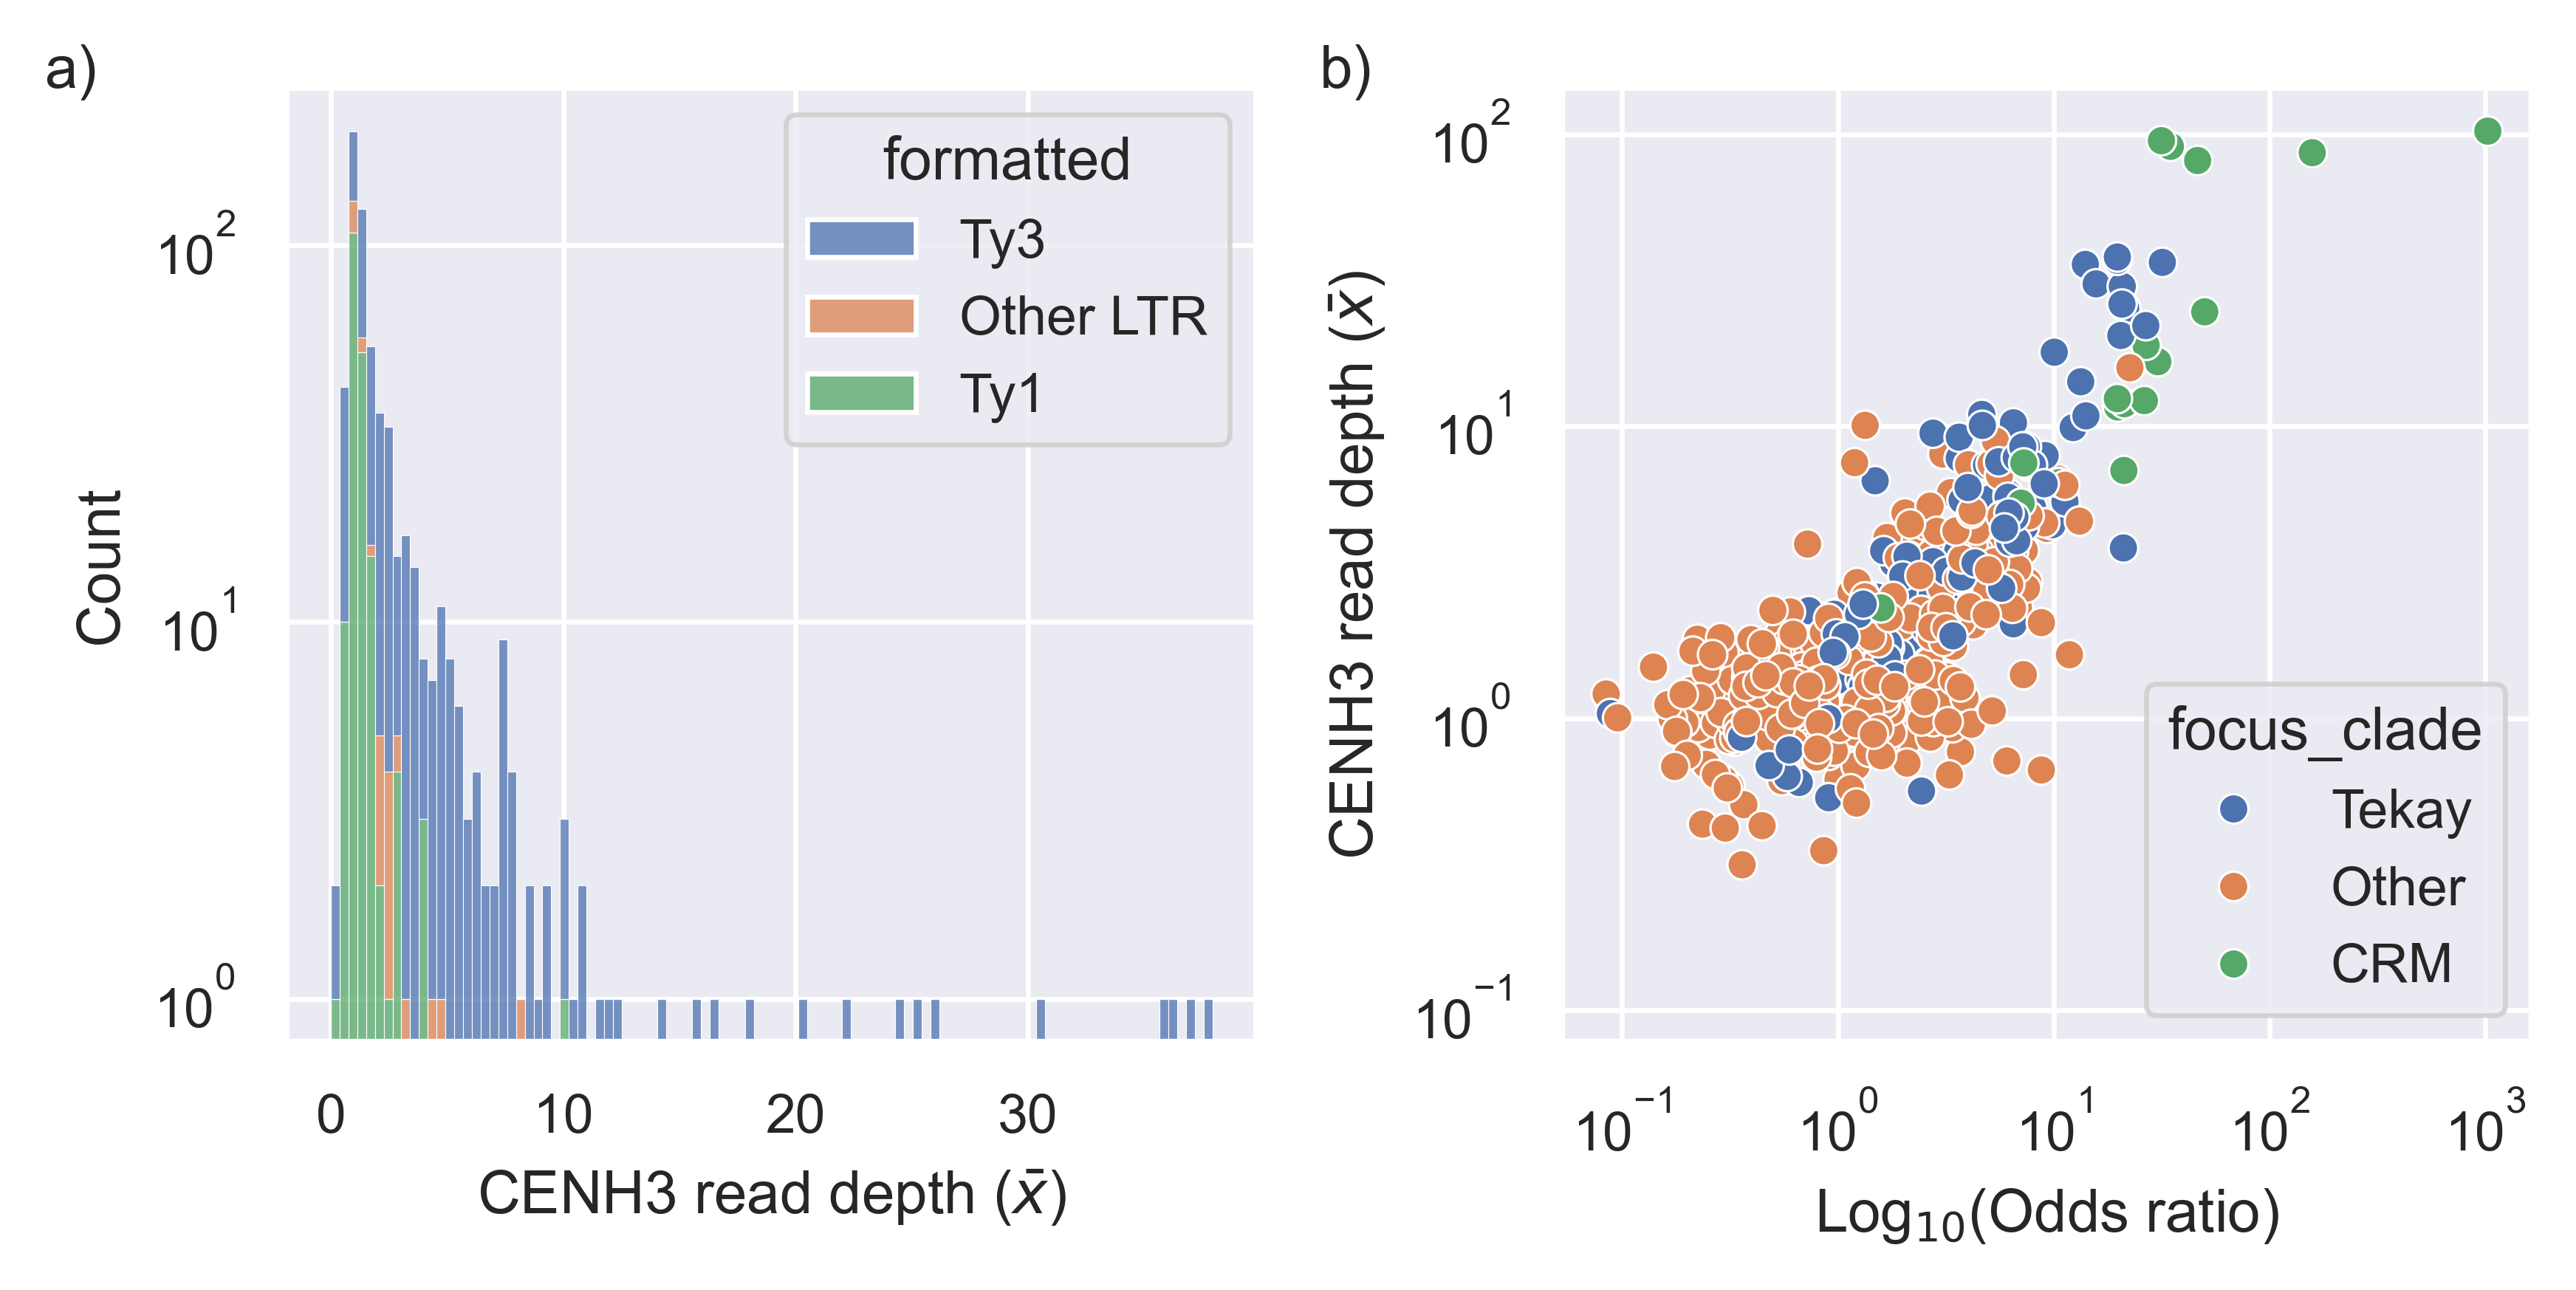

In [32]:
earlgrey_cenh3 = (
    pl.read_csv("../results/earlgrey_cenh3_summary.csv")
    .with_columns(
        (
            pl
            .when(pl.col("column_3").str.contains("Gypsy"))
            .then(pl.lit("Ty3"))
            .when(pl.col("column_3").str.contains("Copia"))
            .then(pl.lit("Ty1"))
            .otherwise(pl.lit("Other LTR"))
            .alias("formatted")
        )
    )
)

cenh3_tesorter_odds = (
    earlgrey_cenh3
    .rename({"ID": "id"})
    .join(tesorter, on="id", how="inner")
    .join(results_df, on="id", how="inner")
    .with_columns(
        (
            pl
            .when(pl.col("Clade") == "CRM")
            .then(pl.lit("CRM"))
            .when(pl.col("Clade") == "Tekay")
            .then(pl.lit("Tekay"))
            .otherwise(pl.lit("Other"))
            .alias("focus_clade")
        )
    )
)

fig = plt.figure(figsize=(5.9, 3), layout="tight", dpi=600)
gs = gridspec.GridSpec(1, 2)

axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]


sns.histplot(
    earlgrey_cenh3.filter(pl.col("column_3").str.contains("LTR")),
    x="sum",
    hue="formatted",
    multiple="stack",
    bins=100,
    ax=axs[0],
)
axs[0].set_yscale("log")
axs[0].set_xlabel(r"CENH3 read depth ($\bar{x}$)")

sns.scatterplot(
    cenh3_tesorter_odds,
    x="odds_ratio",
    y="sum",
    hue="focus_clade",
    ax=axs[1],
)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Log$_{10}$(Odds ratio)")
axs[1].set_ylabel(r"CENH3 read depth ($\bar{x}$)")

for n, ax in enumerate(axs):
    ax.text(
        -0.25,
        1,
        f"{string.ascii_lowercase[n]})",
        transform=ax.transAxes,
    )

plt.savefig("../../pandoc-thesis/figures/earlgrey_cenh3_summary.png")


Use TEsorter as a bit of extra leverage to see what is really enriched for CENH3...

TRASH analysis.
Some nasty manipulation to do here - carried out a bedtools overlap of the TRASH gff file against CENH3 mapping BAM.
Need to get mean coverage of each element by grouping with start and end and chromosome, then use these as a key to get the sequence ID, then probably carry out another mean calculation?

In [34]:
q1 = (
    pl.scan_csv(
        "../results/cenh3/trash_coverage.bed",
        separator="\t",
        has_header=False,
    )
    .select(
        chrom="column_1",
        start="column_4",
        end="column_5",
        coverage="column_11"
    )
    .group_by("chrom", "start", "end")
    .agg(pl.mean("coverage").alias("mean"))
    .with_columns(
        (pl.col("end") - pl.col("start")).alias("length"),
    )
)

trash_cenh3 = q1.collect(streaming=True)

In [35]:
trash_repeats = (
    pl.read_csv(
        "../results/TRASH/all.repeats.from.final_assembly.fa.csv",
    )
    .select(
        chrom="seq.name",
        start="start",
        end="end",
        seq="seq",
    )
)

trash_cenh3 = (
    trash_cenh3
    .join(trash_repeats, on=["chrom", "start", "end"], how="left")
    .join(centromeres, on="chrom", how="left")
    .with_columns(
        ((pl.col("start") > pl.col("start_right")) &
        (pl.col("end") < pl.col("end_right")))
        .alias("inside_centromere"),     
    ) )

/var/folders/v0/ly538751577dz0fqnlb8rj9m0000gn/T/ipykernel_1556/4200448891.py:14: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  trash_cenh3


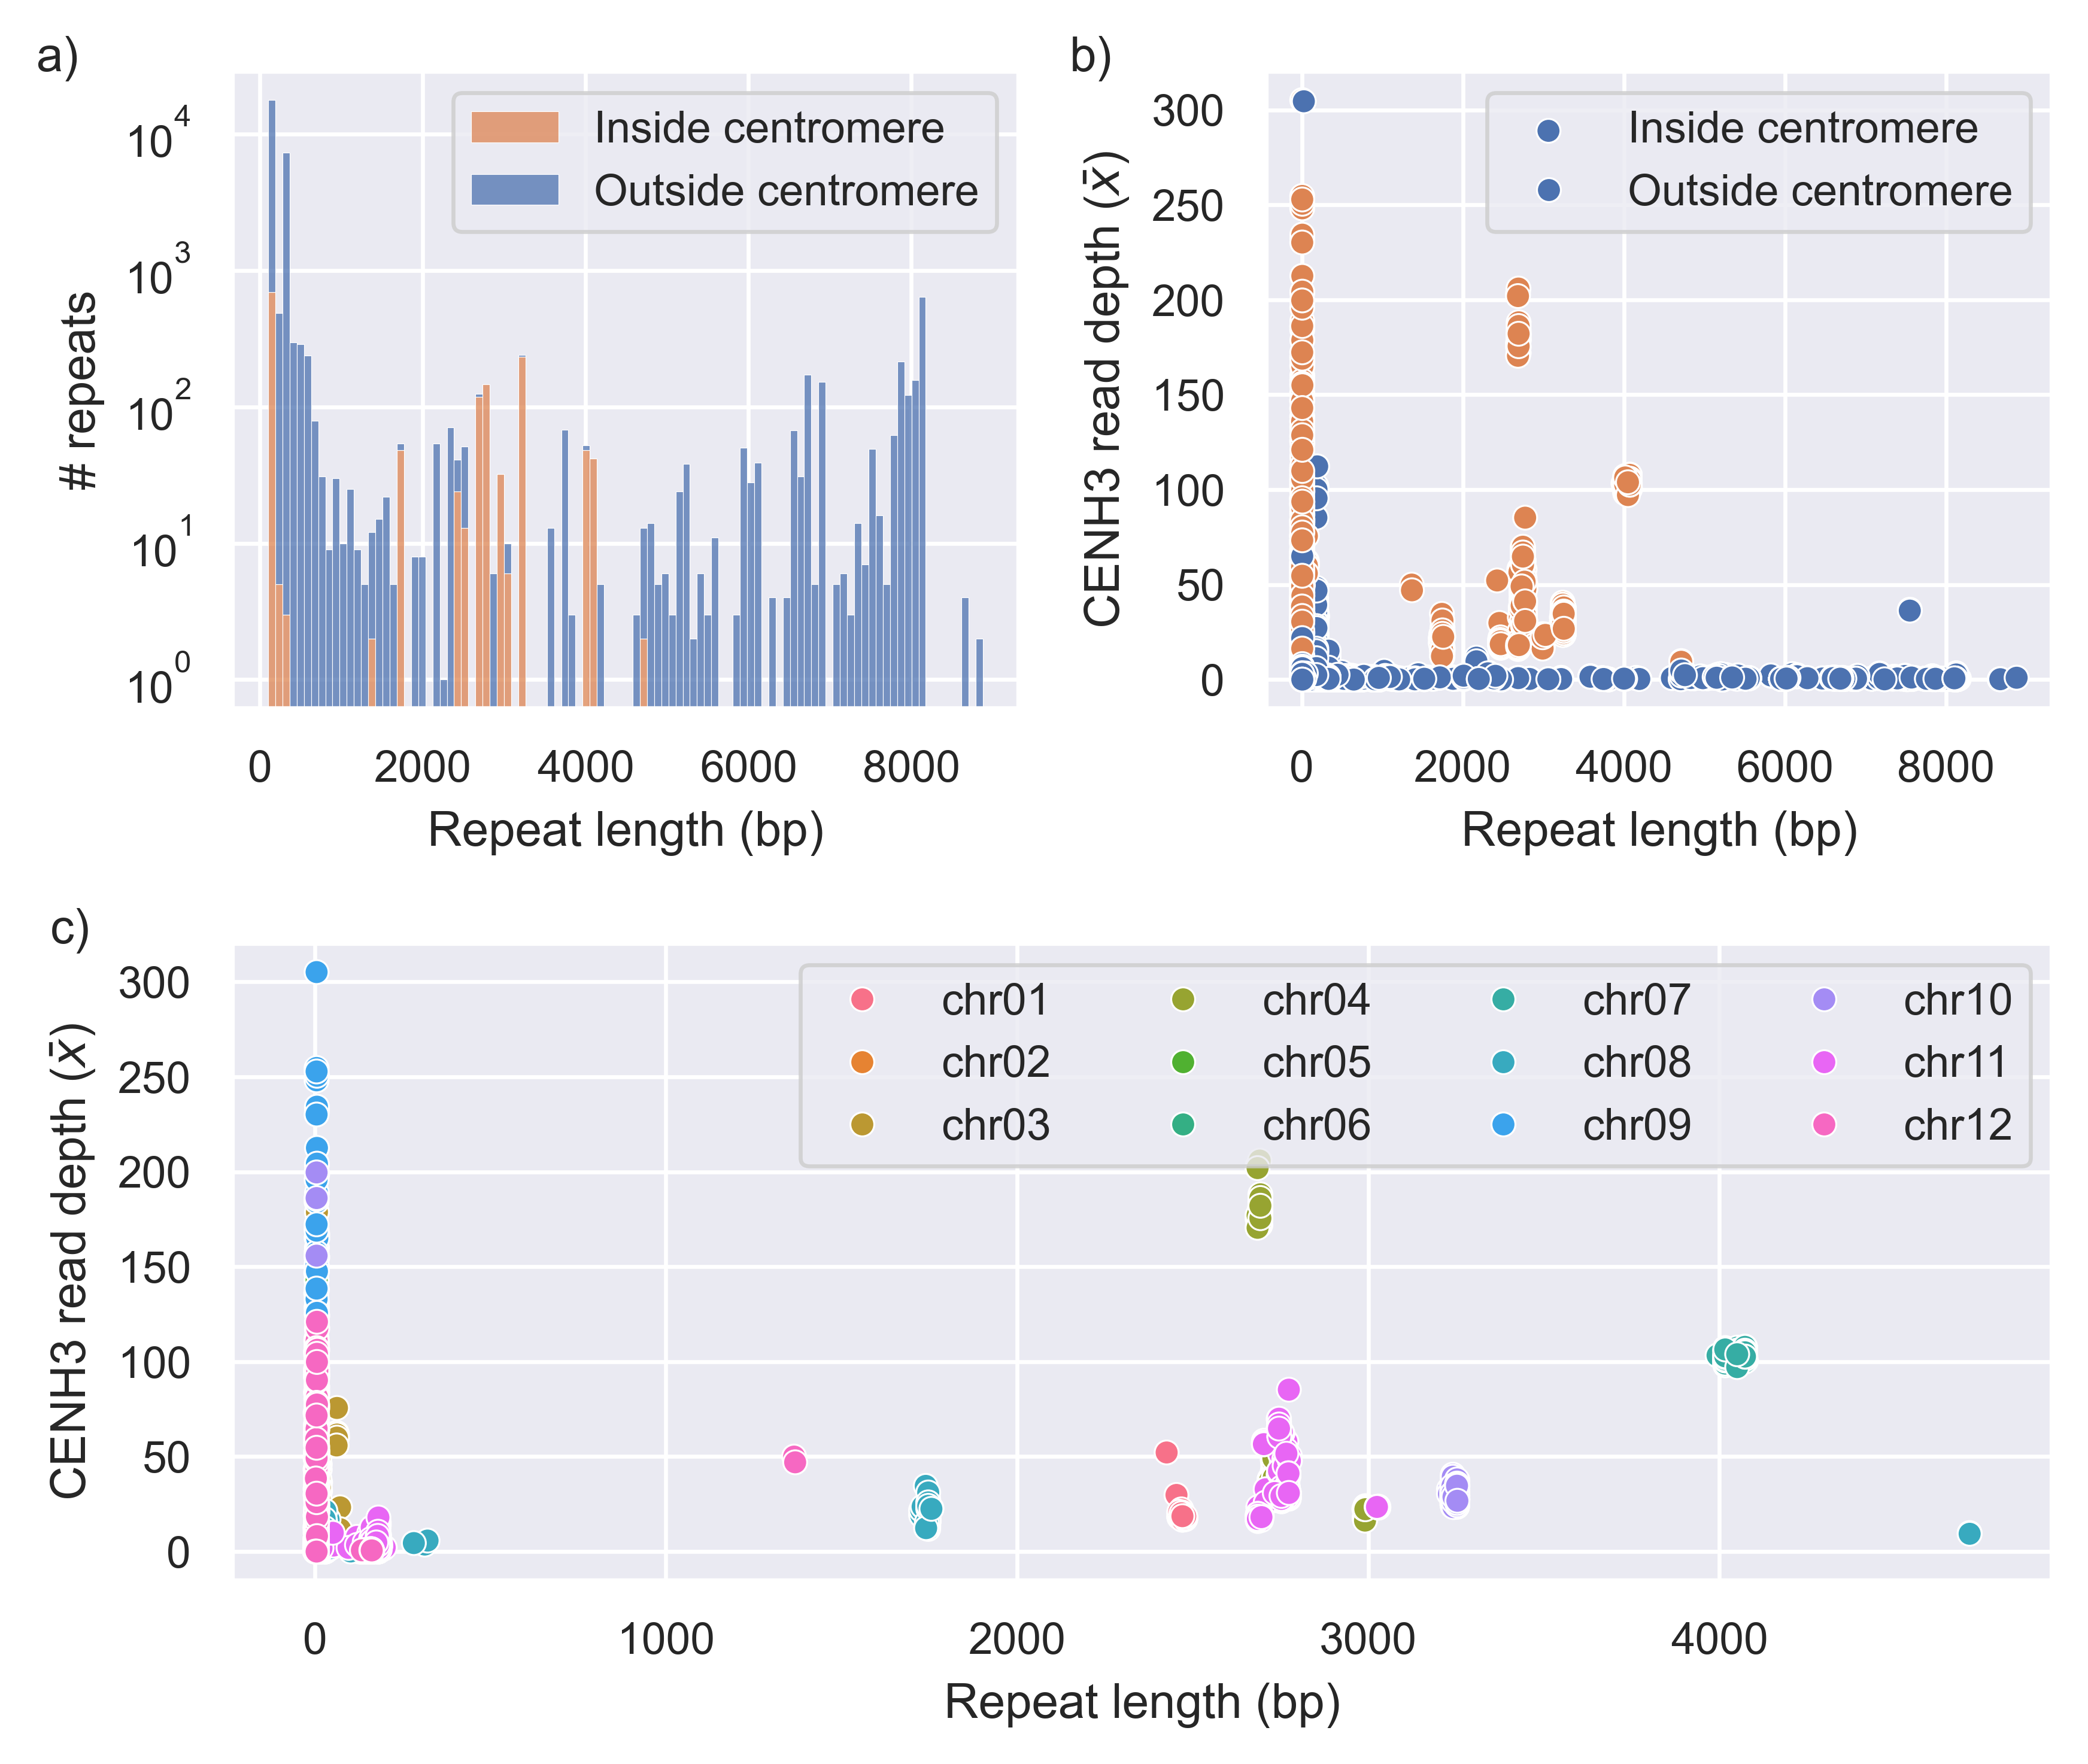

In [36]:
fig = plt.figure(figsize=(5.9, 5), layout="tight", dpi=600)
gs = gridspec.GridSpec(2, 2)

axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, :])]

sns.histplot(
    trash_cenh3.filter(
        (pl.col("chrom").str.contains("chr")) &
        (pl.col("length") > 100)
    ),
    x="length",
    hue="inside_centromere",
    multiple="stack",
    bins=100,
    ax=axs[0],
)
axs[0].set_yscale("log")
axs[0].set(xlabel="Repeat length (bp)", ylabel="# repeats")
axs[0].legend(labels=["Inside centromere", "Outside centromere"])

sns.scatterplot(
    trash_cenh3.filter(
        (pl.col("chrom").str.contains("chr"))
    ),
    x="length",
    y="mean",
    hue="inside_centromere",
    ax=axs[1],
)
axs[1].set(xlabel="Repeat length (bp)", ylabel=r"CENH3 read depth ($\bar{x}$)")
axs[1].legend(labels=["Inside centromere", "Outside centromere"])

sns.scatterplot(
    (
        trash_cenh3
        .filter(
            (pl.col("chrom").str.contains("chr")) & 
            (pl.col("inside_centromere") == True)
        )
        .sort("chrom")
    ),
    x="length",
    y="mean",
    hue="chrom",
    ax=axs[2],
)
axs[2].legend(ncol=4)
axs[2].set(xlabel="Repeat length (bp)", ylabel=r"CENH3 read depth ($\bar{x}$)")

for n, ax in enumerate(axs):
    if n == 2:
        ax.text(
            -0.1,
            1,
            f"{string.ascii_lowercase[n]})",
            transform=ax.transAxes,
        )
    else:
        ax.text(
            -0.25,
            1,
            f"{string.ascii_lowercase[n]})",
            transform=ax.transAxes,
        )

fig.savefig("../../pandoc-thesis/figures/centromere_repeats.png")


From some bespoke blast searches, I think it may be the case that centromeres with repeats are actually being formed by different subclasses - Tekay and CRM elements.

This would be very significant if so.

To verify this I need to find a method of classifying the origins of each TRASH repeat.
I think the best way to do this is to take all TRASH repeats, find non-redundant sequences, blast this library against the te-sorter best hits from the earlgrey library, then annotate trash repeats accordingly.
This will give me an idea of which repeats are of CRM vs Tekay origin.

Getting a non-redudant library should be easy enough, but how to reannotate the bed file? some bedtools magic might work?

Writing this here so I don't forget:
1) bedtools getfasta to get library of trash repeats
2) seqkit rmdup to build a non-redundant library
3) BLASTn against earlgrey library
4) Navigate results to assign to known CRM or Tekay hits (or other)

Easier to do this in the TE notebook I think